<a href="https://colab.research.google.com/github/sumanjitmoshat/CNN/blob/master/intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
### importing required packages
import pathlib
import PIL
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.preprocessing.image import load_img
import numpy
from PIL import Image
import numpy as np
from skimage import transform
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import pandas as pd
from keras import utils as np_utils
import matplotlib.image as img

In [2]:
# connecting with kaggle to download the dataset 
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d puneet6060/intel-image-classification
! mkdir train
! unzip intel-image-classification.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/seg_train/seg_train/mountain/7506.jpg  
  inflating: train/seg_train/seg_train/mountain/7537.jpg  
  inflating: train/seg_train/seg_train/mountain/7539.jpg  
  inflating: train/seg_train/seg_train/mountain/7551.jpg  
  inflating: train/seg_train/seg_train/mountain/7560.jpg  
  inflating: train/seg_train/seg_train/mountain/7565.jpg  
  inflating: train/seg_train/seg_train/mountain/7578.jpg  
  inflating: train/seg_train/seg_train/mountain/7581.jpg  
  inflating: train/seg_train/seg_train/mountain/7586.jpg  
  inflating: train/seg_train/seg_train/mountain/7647.jpg  
  inflating: train/seg_train/seg_train/mountain/7652.jpg  
  inflating: train/seg_train/seg_train/mountain/7654.jpg  
  inflating: train/seg_train/seg_train/mountain/7662.jpg  
  inflating: train/seg_train/seg_train/mountain/767.jpg  
  inflating: train/seg_train/seg_train/mountain/7672.jpg  
  inflating: train/seg_train/seg_train/mountain/7679.jpg  
  infl

In [3]:
### setting path for training and test dataset
data_dir_train= pathlib.Path("train/seg_train/seg_train")
data_dir_test= pathlib.Path("train/seg_test/seg_test")

In [4]:
### checking the count in train and test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))

In [5]:
### printing image count
print(image_count_train)
print(image_count_test)

14034
3000


In [6]:
### setting the batch size to 32 and image height and 
batch_size = 32
img_height = 150
img_width = 150

In [7]:
### intializing the training dataset , keeping 20 % of the data as validaiton set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    seed=123,
    validation_split=0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size= batch_size
    )

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [8]:
### initializing the validation dataset 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_test,
    seed=123,
    validation_split=0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size= batch_size
    )

Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [9]:
### checking the class names
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


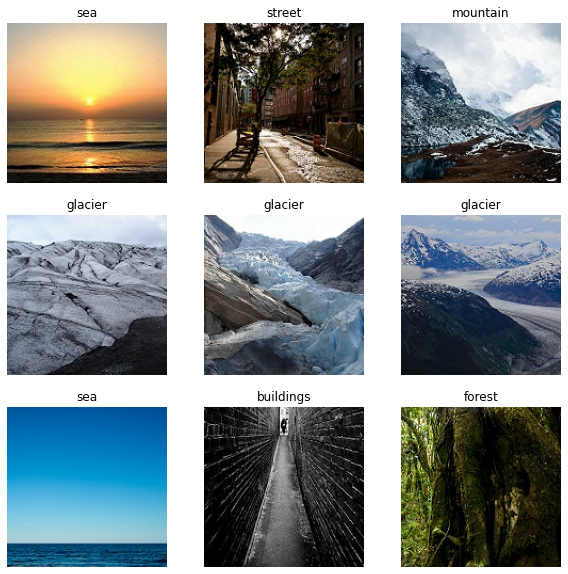

In [10]:
### printing first 9 images from the dataset
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,1+i)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

AUTOTUNE finds the optimal CPU allocation across all parameters . train_ds.cache() keeps the images in memory after they've been loaded off disk during the first epoch . train_ds.prefetch overlaps data pre processing and model execution while training

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Creating the model with 3 convolution layer and 2 dense layer after flattening . The inputs are tensor of 150 * 150 * 3 . They are being normalized in the input as pixel value can take a value in range of 0 to 255

In [12]:
num_classes = 6
epochs=20

In [ ]:
model = Sequential([
            layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
            layers.Conv2D(32,(3,3),padding='same',activation='relu'),
            layers.MaxPooling2D(2,2),
            layers.Conv2D(32,(3,3),padding='same',activation='relu'),
            layers.MaxPooling2D(2,2),
            layers.Flatten(),
            layers.Dense(128,activation='relu'),
            layers.Dense(num_classes,activation='softmax')
                    
])

Using adam(adagrad+rmsprop) as optimizer and SparseCategoricalCrossEntropy as the loss function. And using accuracy as the metrics

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43808)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [ ]:
### training the model for 20 epochs

history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
351/351 [==============================] - 273s 777ms/step - loss: 0.9402 - accuracy: 0.6469 - val_loss: 0.6959 - val_accuracy: 0.7383
Epoch 2/20
351/351 [==============================] - 271s 772ms/step - loss: 0.5815 - accuracy: 0.7922 - val_loss: 0.6450 - val_accuracy: 0.7567
Epoch 3/20
351/351 [==============================] - 271s 773ms/step - loss: 0.3426 - accuracy: 0.8804 - val_loss: 0.6410 - val_accuracy: 0.7833
Epoch 4/20
351/351 [==============================] - 271s 772ms/step - loss: 0.1988 - accuracy: 0.9357 - val_loss: 0.7267 - val_accuracy: 0.7633
Epoch 5/20
351/351 [==============================] - 272s 775ms/step - loss: 0.0880 - accuracy: 0.9741 - val_loss: 0.8428 - val_accuracy: 0.7917
Epoch 6/20
351/351 [==============================] - 272s 774ms/step - loss: 0.0595 - accuracy: 0.9836 - val_loss: 0.9274 - val_accuracy: 0.7767
Epoch 7/20
351/351 [==============================] - 273s 777ms/step - loss: 0.0458 - accuracy: 0.9893 - val_loss: 1.0175 -

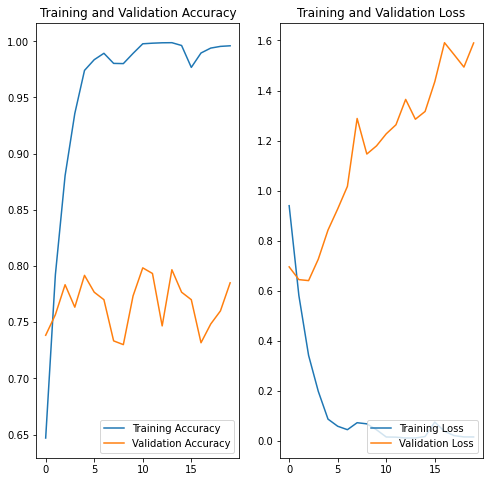

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.show()

As we can see the model is clearly overfitting so introducing dropout to reduce overfitting

In [ ]:
earlystop= EarlyStopping(monitor='val_accuracy', patience=3)

In [15]:
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [16]:
model_dropout = Sequential([
            data_augmentation,   

            layers.experimental.preprocessing.Rescaling(1./255),

            layers.Conv2D(16,(4,4),padding='same',activation='relu'),
            layers.MaxPooling2D(2,2),

            layers.Conv2D(32,(4,4),padding='same',activation='relu'),
            layers.MaxPooling2D(2,2),
            layers.Dropout(0.25),

            layers.Conv2D(64,(4,4),padding='same',activation='relu'),
            layers.MaxPooling2D(2,2),
            layers.Dropout(0.25),

            layers.Flatten(),

            layers.Dense(128,activation='relu'),
            layers.Dropout(0.25),

            layers.Dense(128,activation='relu'),
            layers.Dropout(0.25),
            
            layers.Dense(num_classes)
                    
])

In [17]:
model_dropout.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [18]:
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)       

In [19]:
history_dropout = model_dropout.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
351/351 [==============================] - 386s 1s/step - loss: 1.2778 - accuracy: 0.4933 - val_loss: 1.0427 - val_accuracy: 0.5783
Epoch 2/20
351/351 [==============================] - 366s 1s/step - loss: 0.9824 - accuracy: 0.6295 - val_loss: 0.7984 - val_accuracy: 0.7067
Epoch 3/20
351/351 [==============================] - 358s 1s/step - loss: 0.8681 - accuracy: 0.6744 - val_loss: 0.6727 - val_accuracy: 0.7533
Epoch 4/20
351/351 [==============================] - 359s 1s/step - loss: 0.8071 - accuracy: 0.7040 - val_loss: 0.6851 - val_accuracy: 0.7550
Epoch 5/20
351/351 [==============================] - 360s 1s/step - loss: 0.7754 - accuracy: 0.7203 - val_loss: 0.6888 - val_accuracy: 0.7567
Epoch 6/20
351/351 [==============================] - 365s 1s/step - loss: 0.7179 - accuracy: 0.7368 - val_loss: 0.7496 - val_accuracy: 0.7517
Epoch 7/20
351/351 [==============================] - 370s 1s/step - loss: 0.6844 - accuracy: 0.7494 - val_loss: 0.7109 - val_accuracy: 0.7400

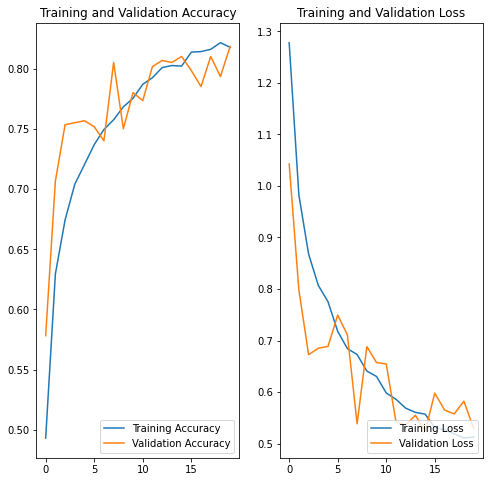

In [20]:
acc = history_dropout.history['accuracy']
val_acc = history_dropout.history['val_accuracy']

loss= history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.show()

In [28]:
def classify_img(img_path):
    '''
    input:path of the image to be classified
    output:image, predicted label of the image
    '''
    proc_img = tf.keras.preprocessing.image.load_img(path=img_path , 
                                                    target_size=(img_height, img_width))
    input_arr = tf.keras.preprocessing.image.img_to_array(proc_img)
    input_arr = np.array([input_arr])
    y_pred = model_dropout.predict(input_arr)
    label = class_names[np.argmax(y_pred)]
    
    image = img.imread(img_path)
    disp = plt.imshow(image)
    plt.title(label)
    plt.show()
    return disp, label

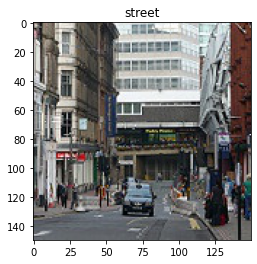

(<matplotlib.image.AxesImage at 0x7f3b5ba95c10>, 'street')

In [30]:
VALIMG0_PATH = '/content/train/seg_pred/seg_pred/10012.jpg'

classify_img(VALIMG0_PATH)